# CosmoDC realizations
## Dependencies

In [1]:
import numpy as np
import pandas as pd
import random
import scipy
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

In [2]:
import GCRCatalogs
from GCR import GCRQuery

## Data
Load flexzboost the catalog

In [3]:
fname = "/global/cfs/cdirs/lsst/groups/WL/projects/star-challenge/cosmodc2/TXPipe-full-output/binned_lens_catalog.hdf5"
hf = h5py.File(fname, "r")

In [4]:
hf.keys()

<KeysViewHDF5 ['lens', 'provenance']>

In [5]:
print(hf["lens"]["bin_0"]["id"][:5])

[9437502326 9437502460 9437502471 9437502490 9437502499]


In [6]:
%%time
cat = GCRCatalogs.load_catalog('CosmoDC2_v1.1.4_image_with_photozs_v1')
zgrid = cat.photoz_pdf_bin_centers

CPU times: user 1.24 s, sys: 4.48 s, total: 5.72 s
Wall time: 1min 19s


In [7]:
quants = cat.list_all_quantities()
qs = []
for q in quants:
    if 'photo' in q:
        qs.append(q)
qs

['mag_err_u_photoz',
 'mag_z_photoz',
 'photoz_mean',
 'mag_err_i_photoz',
 'photoz_mode_ml',
 'mag_r_photoz',
 'photoz_mode_ml_red_chi2',
 'photoz_mode',
 'mag_i_photoz',
 'photoz_mask',
 'mag_y_photoz',
 'mag_err_y_photoz',
 'mag_g_photoz',
 'photoz_pdf',
 'mag_err_r_photoz',
 'mag_u_photoz',
 'photoz_median',
 'mag_err_g_photoz',
 'photoz_odds',
 'mag_err_z_photoz']

In [8]:
basic_cuts = [GCRQuery('photoz_mask==1')]

In [9]:
photo_cat = cat.get_quantities(['galaxy_id', 'photoz_pdf'],
                   return_iterator=True)
i = 0
for photo_q in photo_cat:
    if i<5:
        ids = photo_q['galaxy_id']
        sel_0 = np.isin(ids, hf["lens"]["bin_0"]["id"])
        sel_1 = np.isin(ids, hf["lens"]["bin_1"]["id"])
        sel_2 = np.isin(ids, hf["lens"]["bin_2"]["id"])
        sel_3 = np.isin(ids, hf["lens"]["bin_3"]["id"])
        sel_4 = np.isin(ids, hf["lens"]["bin_4"]["id"])
        id_0 = ids[sel_0]
        id_1 = ids[sel_1]
        id_2 = ids[sel_2]
        id_3 = ids[sel_3]
        id_4 = ids[sel_4]
        photoz_0 = list(photo_q['photoz_pdf'][sel_0])
        photoz_1 = list(photo_q['photoz_pdf'][sel_1])
        photoz_2 = list(photo_q['photoz_pdf'][sel_2])
        photoz_3 = list(photo_q['photoz_pdf'][sel_3])
        photoz_4 = list(photo_q['photoz_pdf'][sel_4])
        
        pzdict_0 = {'id': id_0, 'pdf': photoz_0}
        pzdict_1 = {'id': id_1, 'pdf': photoz_1}
        pzdict_2 = {'id': id_2, 'pdf': photoz_2}
        pzdict_3 = {'id': id_3, 'pdf': photoz_3}
        pzdict_4 = {'id': id_4, 'pdf': photoz_4}
        
        pzdict_0 = pd.DataFrame(pzdict_0)
        pzdict_1 = pd.DataFrame(pzdict_1)
        pzdict_2 = pd.DataFrame(pzdict_2)
        pzdict_3 = pd.DataFrame(pzdict_3)
        pzdict_4 = pd.DataFrame(pzdict_4)

        if i==0:
            total_pzdict_0 = pzdict_0
            total_pzdict_1 = pzdict_1
            total_pzdict_2 = pzdict_2
            total_pzdict_3 = pzdict_3
            total_pzdict_4 = pzdict_4
        else:
            total_pzdict_0 = pd.concat([total_pzdict_0, pzdict_0])
            total_pzdict_1 = pd.concat([total_pzdict_1, pzdict_1])
            total_pzdict_2 = pd.concat([total_pzdict_2, pzdict_2])
            total_pzdict_3 = pd.concat([total_pzdict_3, pzdict_3])
            total_pzdict_4 = pd.concat([total_pzdict_4, pzdict_4])
        print(i, len(total_pzdict_0), len(total_pzdict_1),
             len(total_pzdict_2), len(total_pzdict_3), len(total_pzdict_4))
        i = i+1
    else:
        break
        

0 32648 46153 49556 47706 1399
1 61348 90348 99198 97931 2866
2 90651 130999 149564 138975 4887
3 119872 177349 202057 190040 6568
4 149325 219308 250650 236142 7490


In [10]:
photo_tomos = {}
photo_tomos['0'] = total_pzdict_0
photo_tomos['1'] = total_pzdict_1
photo_tomos['2'] = total_pzdict_2
photo_tomos['3'] = total_pzdict_3
photo_tomos['4'] = total_pzdict_4

In [13]:
lenses_grids = [[0.0, 0.6],
                [0.0, 1.0],
                [0.3, 1.0],
                [0.3, 1.3],
                [0.5, 1.3]]

def make_realizations(photo_tomos, grids,
                   normalize=False, n_samples=1_000):
    for i, tomo_key in enumerate(list(photo_tomos.keys())):
        print(i)
        total_pzdict = photo_tomos[tomo_key]
        pdfs = np.array(total_pzdict['pdf'])
        grid = grids[i]
        print("Generate comulative distributions")
        cdfs_i = []
        for pdf in pdfs:
            norm = np.sum(pdf)
            if normalize:
                pdf = pdf/norm
            cdf = np.cumsum(pdf)
            cdf_i = interp1d(cdf, zgrid, fill_value="extrapolate")
            cdfs_i.append(cdf_i)

        print("Generate samples from interpolators")
        rs = np.array([np.random.uniform() for i in np.arange(n_samples)])
        photo_samples = np.array([cdf_i(rs) for cdf_i in cdfs_i])

        print("Make histograms out of samples")
        zbins = np.linspace(grid[0],grid[1], 26)
        znodes = 0.5*(zbins[1:]+zbins[:-1])
        photo_hists = np.array([np.histogram(samples, bins=zbins, density=False)[0] for samples in photo_samples.T])
        if normalize:
            photo_hists_norms = np.array([np.sum(hist) for hist in photo_hists])
            photo_hists = photo_hists.T/photo_hists_norms
        else:
            photo_hists = photo_hists.T

        file_name = './image_photo_cats/lens_{}'.format(i)
        np.savez(file_name,
                 zgrid=zbins,
                 znodes=znodes,
                 photo_hists=photo_hists)

In [14]:
make_realizations(photo_tomos, lenses_grids)

0
Generate comulative distributions
Generate samples from interpolators


/global/common/software/lsst/gitlab/desc-python-prod/2024-03-04-26-36/py/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Make histograms out of samples
1
Generate comulative distributions
Generate samples from interpolators
Make histograms out of samples
2
Generate comulative distributions
Generate samples from interpolators
Make histograms out of samples
3
Generate comulative distributions
Generate samples from interpolators
Make histograms out of samples
4
Generate comulative distributions
Generate samples from interpolators
Make histograms out of samples


In [15]:
lens_0 = np.load('./image_photo_cats/lens_0.npz', allow_pickle=True)
lens_1 = np.load('./image_photo_cats/lens_1.npz', allow_pickle=True)
lens_2 = np.load('./image_photo_cats/lens_2.npz', allow_pickle=True)
lens_3 = np.load('./image_photo_cats/lens_3.npz', allow_pickle=True)
lens_4 = np.load('./image_photo_cats/lens_4.npz', allow_pickle=True)

lenses = {'lens_0': lens_0,
          'lens_1': lens_1,
          'lens_2': lens_2,
          'lens_3': lens_3,
          'lens_4': lens_4}

In [16]:
np.mean(lens_0['photo_hists'], axis=1).shape

(25,)

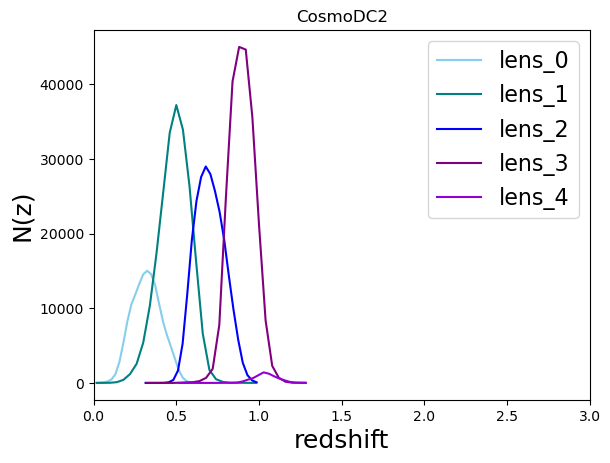

In [17]:
#fig = plt.figure(figsize=(15,8))
colors = ['skyblue', 'teal', 'blue', 'purple', 'darkviolet']
for i, key in enumerate(list(lenses.keys())):
    tomo = lenses[key]
    photo_dz = np.mean(np.diff(tomo['znodes']))
    spec_dz = np.mean(np.diff(zgrid))
    alpha = photo_dz/spec_dz
    #plt.plot(tomo['spec_znodes'], alpha*tomo['spec_hist'], 'k-')
    #plt.plot(tomo['znodes'], tomo['photo_hists'], '-', color=colors[i], alpha=0.01)
    plt.plot(tomo['znodes'], np.mean(tomo['photo_hists'], axis=1), '-', color=colors[i], label=key)

#nzsum = np.sum(fz_df['pdf'])
#plt.plot(zgrid,nzsum,c='b',label=f"i<{magcut} sum p(z)")

plt.xlim([0.0, 3.0])
plt.title("CosmoDC2")
plt.xlabel("redshift",fontsize=18)
plt.ylabel("N(z)",fontsize=18)
plt.legend(loc = 'upper right',fontsize=16);
plt.show()